In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

from utils import *

In [2]:
def load_mmidb_data_dict(DATA_PATH, PARCELLATION, SNR):

    def sort_dict(dict):
        return {k: dict[k] for k in sorted(dict.keys())}

    PARCELLATION_PATH = DATA_PATH + 'mmidb_' + PARCELLATION + '/mmidb_'+ PARCELLATION

    delta_activity = np.load(PARCELLATION_PATH + '_' + str(SNR) + '_1.0_4.0_parallel.npy', allow_pickle=True).item()
    theta_activity = np.load(PARCELLATION_PATH + '_' + str(SNR) + '_4.0_8.0_parallel.npy', allow_pickle=True).item()
    alpha_activity = np.load(PARCELLATION_PATH + '_' + str(SNR) + '_8.0_12.0_parallel.npy', allow_pickle=True).item()
    beta_activity = np.load(PARCELLATION_PATH + '_' + str(SNR) + '_12.0_30.0_parallel.npy', allow_pickle=True).item()
    gamma_activity = np.load(PARCELLATION_PATH + '_' + str(SNR) + '_30.0_70.0_parallel.npy', allow_pickle=True).item()

    data_dict = {
        'Delta': sort_dict(delta_activity),
        'Theta': sort_dict(theta_activity),
        'Alpha': sort_dict(alpha_activity),
        'Beta': sort_dict(beta_activity),
        'Gamma': sort_dict(gamma_activity)
    }

    return data_dict

In [3]:
SNR = 100.0
PARCELLATION = 'aparc.a2009s'
#PARCELLATION = 'HCPMMP1_combined'
DATA_PATH = '/home/williamtheodor/Documents/DL for EEG Classification/data/'

data_dict = load_mmidb_data_dict(DATA_PATH, PARCELLATION, SNR)

In [4]:
band = 'Alpha'

patient = 'S002'
run = 'R03'
FILE = f'../../data/eegmmidb (raw)/files/{patient}/{patient}{run}.edf'

subjects_dir, subject, trans, src_path, bem_path=get_fsaverage()
labels = get_labels(subjects_dir, parcellation_name=PARCELLATION)
label_names = [label.name for label in np.array(labels).flatten()]

raw = get_raw(FILE)
annotations = get_annotations(FILE)

annotation_dict = get_window_dict(raw, annotations)

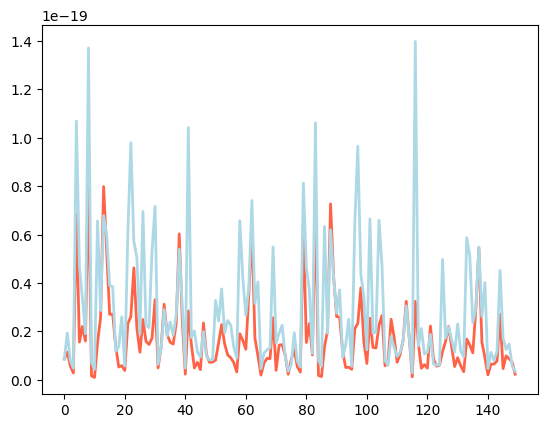

In [5]:
baseline_open = data_dict[band][patient][patient+'R01']['T0'][0]
baseline_closed = data_dict[band][patient][patient+'R02']['T0'][0]

open_color = 'tomato'
closed_color = 'lightblue'

plt.plot(baseline_open, c=open_color, linewidth=2.0)
plt.plot(baseline_closed, c=closed_color, linewidth=2.0)

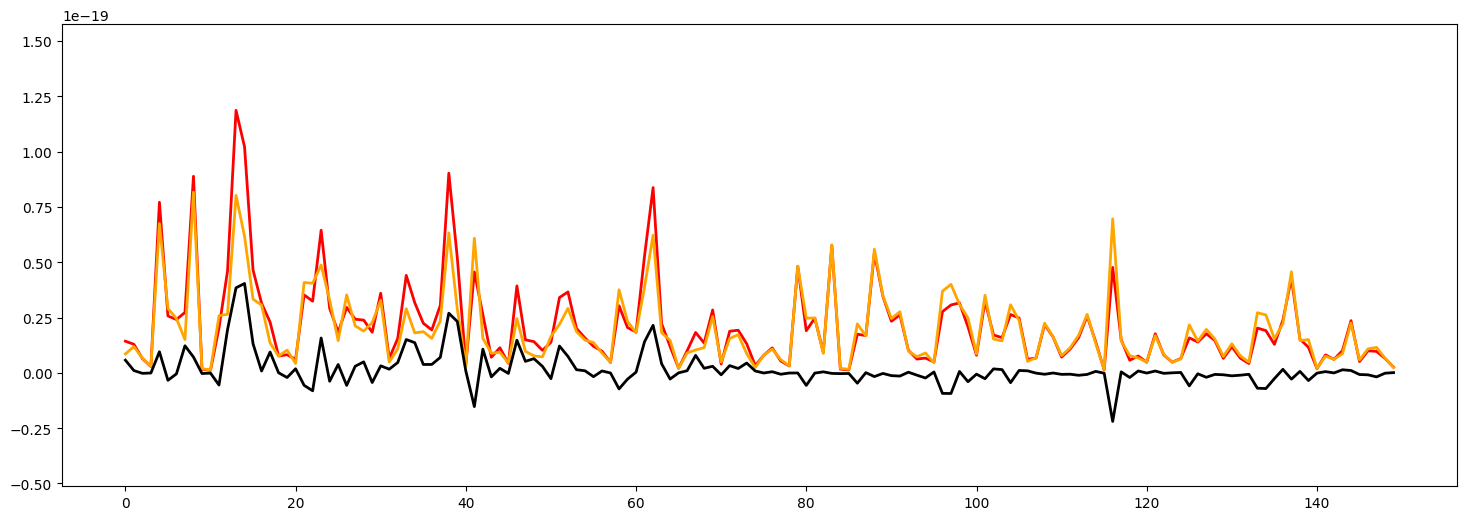

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))

alpha = 0.0
lw_thick = 2
for i in range(7):
    activity_T1 = data_dict['Alpha'][patient][patient+run]['T1'][i]
    activity_T2 = data_dict['Alpha'][patient][patient+run]['T2'][i]
    ax.plot(activity_T1, c='r', alpha=alpha)
    ax.plot(activity_T2, c='orange', alpha=alpha)
    ax.plot(activity_T1 - baseline_open, c='b', alpha=alpha)
    ax.plot(activity_T2 - baseline_open, c='g', alpha=alpha)

#ax.plot(baseline_open, c='k', linewidth=lw_thick)
mean_T1 = np.mean(data_dict['Alpha'][patient][patient+run]['T1'], axis=0)
mean_T2 = np.mean(data_dict['Alpha'][patient][patient+run]['T2'], axis=0)
ax.plot(mean_T1, c='r', linewidth=lw_thick)
ax.plot(mean_T2, c='orange', linewidth=lw_thick)
#ax.plot(mean_T1 - baseline_open, c='b', linewidth=lw_thick)
#ax.plot(mean_T2 - baseline_open, c='g', linewidth=lw_thick)
ax.plot(mean_T1 - mean_T2, c='k', linewidth=lw_thick)

In [7]:
def flatten(l):
    return [item for sublist in l for item in sublist]

raw_list = flatten([annotation_dict[key] for key in annotation_dict.keys()])

In [8]:
all_labels = []

for i in range(len(label_names)):
    all_labels.append(f'{i}')

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(all_labels)

LabelEncoder()

In [9]:
def get_concepts(annotation_dict, data_dict, band, patient, run, baseline_open):


    cutoff = 1000
    x_temp = np.zeros((number_raws, 64, cutoff))
    y_temp = []

    for i, key in enumerate(annotation_dict.keys()):
        for j, raw in enumerate(annotation_dict[key]):
            idx = (i+1)*(j+1)

            try:
                x_temp[idx] = raw.get_data()[:,:cutoff]
            except:
                x_temp[idx] = x_temp[idx]

            window_activity = data_dict[band][patient][patient+run][key][j]
            window_activity -= baseline_open
            region_idx = window_activity.argmax()
            #concept = f"{band}_activity_{key}_{region_idx}"
            #concept = f"{key}_{region_idx}"
            concept = f"{region_idx}"

            #y_temp[idx] = region_idx
            y_temp.append(concept)
    y_temp = np.array(y_temp)

    return x_temp, y_temp


band = 'Alpha'

patients = [key for key in data_dict['Alpha'].keys()]

NUMNER_PATIENTS = len(patients)
NUMBER_RUNS = 12
NUMBER_WINDOWS = 30
NUMBER_CHANNELS = 64
NUMBER_SAMPLES = 1000

runs = [key[-3:] for key in data_dict['Alpha'][patients[0]].keys() if key not in ['S001R01', 'S001R02']]

X = np.zeros((NUMNER_PATIENTS, NUMBER_RUNS, NUMBER_WINDOWS, NUMBER_CHANNELS, NUMBER_SAMPLES))
Y = np.ones((NUMNER_PATIENTS, NUMBER_RUNS, NUMBER_WINDOWS)) * -1

for i, patient in tqdm(enumerate(patients[:50])):
    for j, run in enumerate(runs):

        FILE = f'../../data/eegmmidb (raw)/files/{patient}/{patient}{run}.edf'

        raw = get_raw(FILE)
        annotations = get_annotations(FILE)

        annotation_dict = get_window_dict(raw, annotations)

        number_raws = np.array([len(annotation_dict[key]) for key in annotation_dict]).sum()
        baseline_open = data_dict[band][patient][patient+'R01']['T0'][0]

        X_temp, Y_temp = get_concepts(annotation_dict, data_dict, band, patient, run, baseline_open)
        
        Y_temp_encoded = le.transform(Y_temp)

        try:
            X[i, j] = X_temp
            Y[i, j] = Y_temp_encoded
        except:
            X[i, j] = X[i, j]
            Y[i, j] = Y[i, j]


50it [04:09,  5.00s/it]


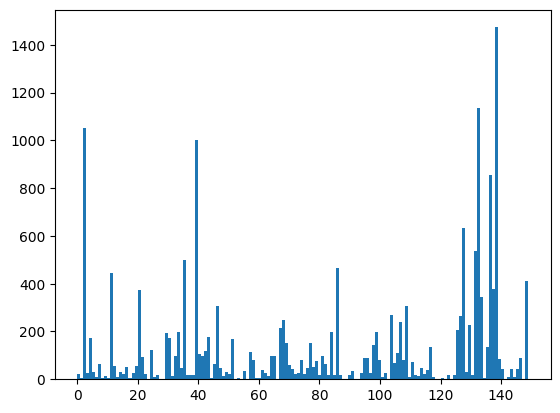

In [14]:
h = plt.hist(Y[Y!=-1].flatten(), bins=len(label_names))

In [34]:
rex = np.argsort(h[0])[::-1]
rex

array([139, 133,   2,  39, 137, 128, 132,  35,  86,  11, 149, 138,  20,
       134, 109,  46, 104, 127,  68, 107, 130,  67, 126,  99,  33,  84,
        29,  43,   4,  30,  51,  69,  77,  98, 136, 117,  24,  42,  57,
       106,  40,  64,  41,  65,  81,  32,  21, 147,  95,  96, 140,  58,
       100, 108,  74,  79, 111, 105,  45,   7,  82,  70,  19,  12,  78,
        16,  47,  76, 114,  34, 141, 144,  71, 146, 116,  61,  91,  55,
       129,  49,   5,  14,   3,  18,  62,  73,  94,  97, 102,   0,  72,
       115,  75,  15,  50,  22,  80, 123,  85,  83, 112,  38,  26, 131,
        90,  87, 125,  36,  37,   9, 113,  63,  31,  48,  25, 118, 101,
       110,  13, 143, 145,   6,  10,  59, 135,   1,  53, 121,   8,  60,
        17,  44,  66,  52,  27,  88, 103,  89, 124,  23, 119,  92, 142,
        54,  93,  56,  28, 148, 120, 122])

In [36]:
for idx in range(10):
    print(label_names[rex[idx]])

S_parieto_occipital-rh
S_oc_middle_and_Lunatus-rh
G_and_S_cingul-Mid-Ant-lh
Lat_Fis-ant-Vertical-lh
S_orbital_lateral-rh
S_front_sup-rh
S_oc-temp_med_and_Lingual-rh
G_temp_sup-Plan_tempo-lh
G_cuneus-rh
G_cuneus-lh


In [11]:
np.save(f'../../data/X_{band}_raw.npy', X)
np.save(f'../../data/Y_{band}_raw.npy', Y)